In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install torch torchvision pytorch-fid  torchinfo
from pytorch_fid import fid_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchinfo
from torchvision import datasets, transforms

In [ ]:
# Function to load dataset from a .npz file
def load_dataset(file_path):
    """
    Loads the dataset from the given file path.
    Args:
        file_path (str): Path to the .npz file containing the dataset.
    Returns:
        torch.Tensor: Tensor containing the images with an added channel dimension.
    """
    dataset = np.load(file_path, allow_pickle=True, encoding='latin1')
    images = dataset['imgs']  # Extract images from the dataset
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    print(f"Dataset shape: {images.shape}")  # Print the shape of the dataset
    return images

# Function to create a DataLoader for the dataset
def create_dataloader(images, batch_size=128):
    """
    Creates a DataLoader for the given dataset.
    Args:
        images (torch.Tensor): Tensor containing the dataset images.
        batch_size (int): Number of samples per batch.
    Returns:
        DataLoader: DataLoader object for iterating over the dataset.
    """
    dataset = TensorDataset(images)  # Wrap the images in a TensorDataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Create and return DataLoader

# Function to save a subset of real images for FID calculation
def save_dataset_images(images, save_folder, num_images=5000):
    """
    Saves a subset of real images to a specified folder.
    Args:
        images (torch.Tensor): Tensor containing the dataset images.
        save_folder (str): Folder path to save the images.
        num_images (int): Number of images to save.
    """
    os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist
    for idx in range(num_images):
        img = images[idx].unsqueeze(0)  # Add batch dimension
        save_image(img, os.path.join(save_folder, f"{idx}.png"))  # Save image
    print(f"Saved {num_images} images to {save_folder}")

# Load and prepare data
data_path = "/content/drive/MyDrive/Colab Notebooks/sh3_sc6_y32_x32_imgs.npz"  # Path to dataset
image_data = load_dataset(data_path)  # Load dataset
data_loader = create_dataloader(image_data)  # Create DataLoader
save_dataset_images(image_data, "real_images")  # Save real images for FID calculation

Dataset shape: torch.Size([18432, 1, 64, 64])
Saved 5000 images to real_images


In [ ]:
# Encoder module for the VAE
class FeatureEncoder(nn.Module):
    """
    Encoder module that maps input images to a latent space.
    Args:
        latent_size (int): Dimensionality of the latent space.
    """
    def __init__(self, latent_size=10):
        super().__init__()
        # Convolutional layers to extract features
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, 2, 1),  # 4x4
            nn.ReLU(),
            nn.Conv2d(64, 256, 4, 1, 0),  # 1x1
            nn.ReLU()
        )
        # Fully connected layers to output mean and log variance
        self.fc_mean = nn.Linear(256, latent_size)
        self.fc_logvar = nn.Linear(256, latent_size)

    def forward(self, x):
        """
        Forward pass for the encoder.
        Args:
            x (torch.Tensor): Input image tensor.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and log variance of the latent space.
        """
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output
        return self.fc_mean(x), self.fc_logvar(x)  # Return mean and log variance

# Decoder module for the VAE
class ImageDecoder(nn.Module):
    """
    Decoder module that maps latent vectors back to images.
    Args:
        latent_size (int): Dimensionality of the latent space.
    """
    def __init__(self, latent_size=10):
        super().__init__()
        # Fully connected layer to expand latent vector
        self.fc = nn.Linear(latent_size, 256)
        # Transposed convolutional layers to reconstruct the image
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 1, 0),  # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 4, 2, 1),   # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),    # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),    # 32x32 -> 64x64
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1)  # Final convolution to produce output image
        )

    def forward(self, z):
        """
        Forward pass for the decoder.
        Args:
            z (torch.Tensor): Latent vector.
        Returns:
            torch.Tensor: Reconstructed image.
        """
        z = F.relu(self.fc(z))  # Pass through fully connected layer
        z = z.view(z.size(0), 256, 1, 1)  # Reshape for transposed convolutions
        return torch.sigmoid(self.deconv_layers(z))  # Apply sigmoid to output image

# Variational Autoencoder (VAE) model
class VariationalAutoencoder(nn.Module):
    """
    VAE model combining the encoder and decoder.
    Args:
        encoder (nn.Module): Encoder module.
        decoder (nn.Module): Decoder module.
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def sample_latent(self, mean, logvar):
        """
        Samples a latent vector using the reparameterization trick.
        Args:
            mean (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.
        Returns:
            torch.Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        noise = torch.randn_like(std)  # Random noise
        return mean + noise * std  # Reparameterization trick

    def forward(self, x):
        """
        Forward pass for the VAE.
        Args:
            x (torch.Tensor): Input image tensor.
        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Reconstructed image, mean, and log variance.
        """
        mean, logvar = self.encoder(x)  # Encode input to latent space
        z = self.sample_latent(mean, logvar)  # Sample latent vector
        return self.decoder(z), mean, logvar  # Decode latent vector to image

Epoch [1/350], Loss: 1465.0225
Epoch [2/350], Loss: 625.7730
Epoch [3/350], Loss: 585.8217
Epoch [4/350], Loss: 571.8550
Epoch [5/350], Loss: 379.8019
Epoch [6/350], Loss: 206.5350
Epoch [7/350], Loss: 194.9794
Epoch [8/350], Loss: 188.6692
Epoch [9/350], Loss: 145.6402
Epoch [10/350], Loss: 113.7462
Epoch [11/350], Loss: 110.6226
Epoch [12/350], Loss: 108.2992
Epoch [13/350], Loss: 106.4950
Epoch [14/350], Loss: 105.1849
Epoch [15/350], Loss: 103.0595
Epoch [16/350], Loss: 100.6852
Epoch [17/350], Loss: 97.3592
Epoch [18/350], Loss: 93.4740
Epoch [19/350], Loss: 89.1841
Epoch [20/350], Loss: 85.4692
Epoch [21/350], Loss: 82.3733
Epoch [22/350], Loss: 79.8372
Epoch [23/350], Loss: 77.5694
Epoch [24/350], Loss: 75.6418
Epoch [25/350], Loss: 74.4171
Epoch [26/350], Loss: 73.1884
Epoch [27/350], Loss: 71.6599
Epoch [28/350], Loss: 70.3879
Epoch [29/350], Loss: 69.7436
Epoch [30/350], Loss: 68.2174
Epoch [31/350], Loss: 67.4934
Epoch [32/350], Loss: 66.4598
Epoch [33/350], Loss: 65.3716
Ep

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 423MB/s]
100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


FID: 122.87782619939384


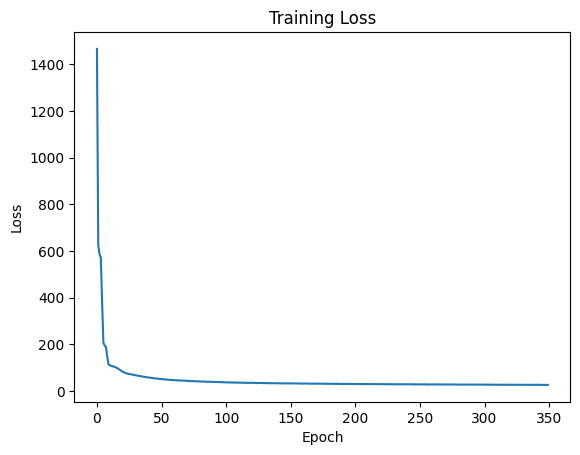

In [ ]:
# Function to compute VAE loss
def compute_vae_loss(reconstructed, original, mean, logvar):
    """
    Computes the VAE loss (reconstruction loss + KL divergence).
    Args:
        reconstructed (torch.Tensor): Reconstructed image.
        original (torch.Tensor): Original image.
        mean (torch.Tensor): Mean of the latent distribution.
        logvar (torch.Tensor): Log variance of the latent distribution.
    Returns:
        torch.Tensor: Total loss.
    """
    reconstruction_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')  # Reconstruction loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())  # KL divergence
    return reconstruction_loss + kl_loss  # Total loss

# Function to train the VAE model
def train_model(model, data_loader, num_epochs, device):
    """
    Trains the VAE model.
    Args:
        model (nn.Module): VAE model to train.
        data_loader (DataLoader): DataLoader for the training dataset.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to train on (CPU or GPU).
    Returns:
        List[float]: List of average losses per epoch.
    """
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer
    loss_history = []  # List to store loss values
    for epoch in range(num_epochs):
        total_loss = 0  # Accumulate loss for the epoch
        for batch in data_loader:
            x = batch[0].to(device)  # Move batch to device
            optimizer.zero_grad()  # Clear gradients
            reconstructed, mean, logvar = model(x)  # Forward pass
            loss = compute_vae_loss(reconstructed, x, mean, logvar)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            total_loss += loss.item()  # Accumulate loss
        avg_loss = total_loss / len(data_loader.dataset)  # Average loss for the epoch
        loss_history.append(avg_loss)  # Store average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print progress
    return loss_history

# Function to generate and save images using the trained model
def generate_and_save_images(model, num_images, save_folder, latent_size=10):
    """
    Generates and saves images using the trained model.
    Args:
        model (nn.Module): Trained VAE model.
        num_images (int): Number of images to generate.
        save_folder (str): Folder to save the generated images.
        latent_size (int): Dimensionality of the latent space.
    """
    model.eval()  # Set model to evaluation mode
    os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist
    with torch.no_grad():  # Disable gradient computation
        for i in range(num_images):
            z = torch.randn(1, latent_size).to(device)  # Sample latent vector
            img = model.decoder(z).squeeze().cpu()  # Generate image
            save_image(img, os.path.join(save_folder, f"{i}.png"))  # Save image

# Function to calculate FID score
def calculate_fid_score(real_folder, generated_folder):
    """
    Calculates the FID score between real and generated images.
    Args:
        real_folder (str): Folder containing real images.
        generated_folder (str): Folder containing generated images.
    Returns:
        float: FID score.
    """
    return fid_score.calculate_fid_given_paths([real_folder, generated_folder], batch_size=64, device=device, dims=2048)

# Train the VAE model
latent_size = 10  # Dimensionality of the latent space
encoder = FeatureEncoder(latent_size)  # Initialize encoder
decoder = ImageDecoder(latent_size)  # Initialize decoder
vae_model = VariationalAutoencoder(encoder, decoder).to(device)  # Initialize VAE model
losses = train_model(vae_model, data_loader, num_epochs=350, device=device)  # Train model

# Generate images and compute FID score
generate_and_save_images(vae_model, num_images=5000, save_folder="generated_vae")  # Generate images
fid_value = calculate_fid_score("real_images", "generated_vae")  # Compute FID score
print(f"FID: {fid_value}")  # Print FID score

# Plot training loss
plt.plot(losses)  # Plot loss values
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Training Loss")  # Plot title
plt.show()  # Display plot

control vae

In [ ]:
# ControlVAE model with dynamic beta adjustment

# Function to train the ControlVAE model
class ControlledVAE(nn.Module):

    def __init__(self, encoder, decoder, latent_size=10, Kp=0.01, Ki=0.001, beta_min=0, target_kl=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.Kp = Kp  # Proportional gain
        self.Ki = Ki  # Integral gain
        self.beta_min = beta_min  # Minimum beta value
        self.target_kl = target_kl  # Target KL divergence
        self.integral_error = 0  # Accumulated error for integral control

    def sample_latent(self, mean, logvar):

        std = torch.exp(0.5 * logvar)  # Standard deviation
        noise = torch.randn_like(std)  # Random noise
        return mean + noise * std  # Reparameterization trick

    def forward(self, x):

        mean, logvar = self.encoder(x)  # Encode input to latent space
        z = self.sample_latent(mean, logvar)  # Sample latent vector
        return self.decoder(z), mean, logvar  # Decode latent vector to image

    def adjust_beta(self, kl_divergence):

        error = self.target_kl - kl_divergence  # Error from target KL
        self.integral_error += error  # Accumulate error for integral control
        beta = self.Kp / (1 + torch.exp(torch.tensor(error))) - self.Ki * self.integral_error + self.beta_min  # Adjust beta
        return torch.clamp(beta, min=0, max=10)  # Clamp beta to [0, 10]

    def compute_loss(self, reconstructed, original, mean, logvar, beta):

        reconstruction_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')  # Reconstruction loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())  # KL divergence
        return reconstruction_loss + beta * kl_loss  # Total loss

def train_controlled_model(model, data_loader, num_epochs, device, optimizer):
    """
    Trains the ControlVAE model.
    Args:
        model (nn.Module): ControlVAE model to train.
        data_loader (DataLoader): DataLoader for the training dataset.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to train on (CPU or GPU).
        optimizer (torch.optim.Optimizer): Optimizer for training.
    Returns:
        Dict[str, List[float]]: Dictionary containing lists of metrics per epoch.
    """
    metrics = {'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'kl_values': [], 'beta_values': []}  # Metrics storage
    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate loss for the epoch
        for batch in data_loader:
            x = batch[0].to(device)  # Move batch to device
            optimizer.zero_grad()  # Clear gradients
            reconstructed, mean, logvar = model(x)  # Forward pass
            kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())  # Compute KL divergence
            beta = model.adjust_beta(kl_divergence.item())  # Adjust beta
            loss = model.compute_loss(reconstructed, x, mean, logvar, beta)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            epoch_loss += loss.item()  # Accumulate loss
        avg_loss = epoch_loss / len(data_loader.dataset)  # Average loss for the epoch
        metrics['total_loss'].append(avg_loss)  # Store average loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print progress
    return metrics
# Train ControlVAE with setpoint=8
print("Training ControlVAE with Setpoint=8...")
latent_size = 10  # Dimensionality of the latent space
encoder_8 = FeatureEncoder(latent_size)  # New encoder instance
decoder_8 = ImageDecoder(latent_size)  # New decoder instance
controlled_vae_8 = ControlledVAE(encoder_8, decoder_8, latent_size=10, target_kl=8).to(device)  # Initialize ControlVAE with setpoint=8
optimizer_8 = optim.Adam(controlled_vae_8.parameters(), lr=0.0001)  # New optimizer instance
metrics_8 = train_controlled_model(controlled_vae_8, data_loader, num_epochs=350, device=device, optimizer=optimizer_8)  # Train model

# Train ControlVAE with setpoint=20
print("Training ControlVAE with Setpoint=20...")
encoder_20 = FeatureEncoder(latent_size)  # New encoder instance
decoder_20 = ImageDecoder(latent_size)  # New decoder instance
controlled_vae_20 = ControlledVAE(encoder_20, decoder_20, latent_size=10, target_kl=20).to(device)  # Initialize ControlVAE with setpoint=20
optimizer_20 = optim.Adam(controlled_vae_20.parameters(), lr=0.0001)  # New optimizer instance
metrics_20 = train_controlled_model(controlled_vae_20, data_loader, num_epochs=350, device=device, optimizer=optimizer_20)  # Train model



Training ControlVAE with Setpoint=8...
Epoch [1/350], Loss: 1508.5848
Epoch [2/350], Loss: 627.3458
Epoch [3/350], Loss: 580.3342
Epoch [4/350], Loss: 465.9171
Epoch [5/350], Loss: 301.8319
Epoch [6/350], Loss: 245.3927
Epoch [7/350], Loss: 227.0818
Epoch [8/350], Loss: 215.6124
Epoch [9/350], Loss: 208.7405
Epoch [10/350], Loss: 204.6217
Epoch [11/350], Loss: 201.6848
Epoch [12/350], Loss: 198.7472
Epoch [13/350], Loss: 196.5178
Epoch [14/350], Loss: 195.1243
Epoch [15/350], Loss: 193.6197
Epoch [16/350], Loss: 191.9674
Epoch [17/350], Loss: 190.5589
Epoch [18/350], Loss: 189.5174
Epoch [19/350], Loss: 188.4444
Epoch [20/350], Loss: 187.2069
Epoch [21/350], Loss: 185.5223
Epoch [22/350], Loss: 185.0381
Epoch [23/350], Loss: 183.8652
Epoch [24/350], Loss: 182.4187
Epoch [25/350], Loss: 182.0270
Epoch [26/350], Loss: 180.4183
Epoch [27/350], Loss: 180.1350
Epoch [28/350], Loss: 178.9104
Epoch [29/350], Loss: 178.7742
Epoch [30/350], Loss: 177.6017
Epoch [31/350], Loss: 177.5707
Epoch [3

In [ ]:
def generate_and_save_images(model, num_images, save_folder, latent_size=10):
    """
    Generates and saves images using the trained model.
    Args:
        model (nn.Module): Trained VAE model.
        num_images (int): Number of images to generate.
        save_folder (str): Folder to save the generated images.
        latent_size (int): Dimensionality of the latent space.
    """
    model.eval()  # Set model to evaluation mode
    os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist
    with torch.no_grad():  # Disable gradient computation
        for i in range(num_images):
            z = torch.randn(1, latent_size).to(device)  # Sample latent vector
            img = model.decoder(z).squeeze().cpu()  # Generate image
            save_image(img, os.path.join(save_folder, f"{i}.png"))  # Save image

In [ ]:
def calculate_fid_score(real_folder, generated_folder):
    """
    Calculates the FID score between real and generated images.
    Args:
        real_folder (str): Folder containing real images.
        generated_folder (str): Folder containing generated images.
    Returns:
        float: FID score.
    """
    return fid_score.calculate_fid_given_paths([real_folder, generated_folder], batch_size=64, device=device, dims=2048)

In [ ]:
# Generate images for setpoint=8
generate_and_save_images(controlled_vae_8, num_images=5000, save_folder="generated_vae_8", latent_size=latent_size)

# Generate images for setpoint=20
generate_and_save_images(controlled_vae_20, num_images=5000, save_folder="generated_vae_20", latent_size=latent_size)

# Compute FID for setpoint=8
fid_8 = calculate_fid_score("real_images", "generated_vae_8")
print(f"FID for setpoint=8: {fid_8}")

# Compute FID for setpoint=20
fid_20 = calculate_fid_score("real_images", "generated_vae_20")
print(f"FID for setpoint=20: {fid_20}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 305MB/s]
100%|██████████| 79/79 [00:18<00:00,  4.24it/s]


FID for setpoint=8: 133.30988299553294


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


FID for setpoint=20: 135.89139240396682


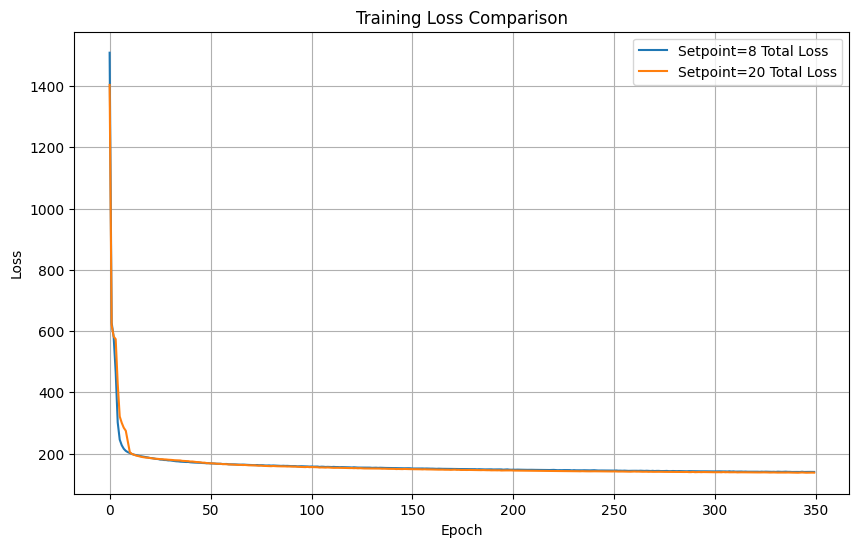

In [ ]:
def plot_loss_comparison(metrics_8, metrics_20):
    """
    Plots the training loss comparison for setpoint=8 and setpoint=20.
    Args:
        metrics_8 (Dict[str, List[float]]): Training metrics for setpoint=8.
        metrics_20 (Dict[str, List[float]]): Training metrics for setpoint=20.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_8['total_loss'], label='Setpoint=8 Total Loss')
    plt.plot(metrics_20['total_loss'], label='Setpoint=20 Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the loss comparison
plot_loss_comparison(metrics_8, metrics_20)

2_Question

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the learning rate for the optimizer
lr = 0.0002

# Define the number of epochs for training the model
num_epochs = 50

In [ ]:
# Define a series of transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize(28),  # Resize images to the specified image size (28x28)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the images to have mean 0.5 and standard deviation 0.5
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for batching and shuffling the dataset
dataloader = DataLoader(dataset,
                        batch_size=128,#[256, 128, 64, 32, 16, 8] Set the batch size
                        shuffle=True,  # Shuffle the dataset for each epoch
                        drop_last=True  # Drop the last incomplete batch if it is smaller than batch_size
                        )
# بررسی تعداد ردیف‌ها در دیتاست
num_samples = len(dataset)
print(f"row in datasets : {num_samples}")  # باید 60000 برای مجموعه آموزش باشد

row in datasets : 60000


# Create a Generator class

In [ ]:


# Define a Generator class that inherits from nn.Module
class MyGenerator(nn.Module):
    def __init__(self, latent_dim=64, img_channels=1, img_size=28):
        super(MyGenerator, self).__init__()  # Initialize the base class

        # Construct the neural network architecture
        self.network = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            # Transition from 512 units to a larger dimensional space
            nn.Linear(512, 64 * 8 * 8),  # Fully connected layer expanding to 64*8*8 units
            nn.BatchNorm1d(64 * 8 * 8),  # Normalize the batch
            nn.ReLU(),  # Non-linear activation

            # Reshape the output to fit convolutional input requirements
            nn.Unflatten(1, (64, 8, 8)),  # Reshape to (batch_size, 64, 8, 8)

            # First upsampling phase with PixelShuffle
            nn.PixelShuffle(2),  # Upscale the dimensions from (64, 8, 8) to (16, 16, 16)
            nn.BatchNorm2d(16),  # Apply batch normalization

            # Convolutional layer to increase the number of channels
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 2D convolution with 32 output channels
            nn.BatchNorm2d(32),  # Normalize the batch
            nn.ReLU(),  # Non-linear activation

            # Second upsampling with PixelShuffle
            nn.PixelShuffle(2),  # Further upscale dimensions while reducing the number of channels
            nn.BatchNorm2d(8),  # Normalize the batch

            # Final convolutional layers to produce the output image
            nn.Conv2d(8, img_channels, kernel_size=3, padding=1),  # Produce the final number of channels
            nn.Upsample(size=(img_size, img_size), mode='bilinear'),  # Resize to the target image dimensions
            nn.Sigmoid()  # Activate to output values in the range [0, 1]
        )

    # Method for the forward pass through the generator
    def forward(self, input_vector):
        return self.network(input_vector)  # Forward the input through the network

# Create a Discriminator class

In [ ]:
import torch
import torch.nn as nn

# Create a Discriminator class derived from nn.Module
class MyDiscriminator(nn.Module):
    def __init__(self):
        super(MyDiscriminator, self).__init__()  # Call the base class constructor

        # Set up the architecture of the model using a sequential container
        self.network = nn.Sequential(
            # Initial convolutional layer: 1 input channel to 32 output channels
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output shape: 32x14x14
            nn.ReLU(),  # ReLU activation function for non-linearity
            nn.BatchNorm2d(32),  # Normalize the batch

            # Second convolutional layer: 32 input channels to 64 output channels
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output shape: 64x7x7
            nn.ReLU(),  # ReLU activation function
            nn.BatchNorm2d(64),  # Normalize the batch

            # Flatten the output for subsequent fully connected layers
            nn.Flatten(),  # Transform the 3D tensor to a 1D tensor

            # First dense layer: 64*7*7 inputs leading to 512 outputs
            nn.Linear(64 * 7 * 7, 512),  # Input size should match the flattened output
            nn.ReLU(),  # ReLU activation function
            nn.BatchNorm1d(512),  # Normalize the batch

            # Second dense layer: 512 inputs to a single output
            nn.Linear(512, 1),  # Final layer outputs a single score (real or fake)

            # Sigmoid activation function to produce a probability score
            nn.Sigmoid()  # This provides a probability value between 0 and 1
        )

    # Method for the forward pass through the discriminator
    def forward(self, input_tensor):
        return self.network(input_tensor)  # Forward the input through the model

# Set up optimizers and generator loss and discriminator loss

In [ ]:


# Function to compute the loss for the generator
def compute_generator_loss(predicted_fake):
    # Non-saturating loss approach for the generator
    return -torch.mean(torch.log(predicted_fake))

# Function to compute the loss for the discriminator
def compute_discriminator_loss(actual_output, predicted_output):
    # Non-saturating loss approach for the discriminator
    loss_real = -torch.mean(torch.log(actual_output))  # Calculate loss for real images
    loss_fake = -torch.mean(torch.log(1 - predicted_output))  # Calculate loss for fake images
    return loss_real + loss_fake  # Aggregate total loss for the discriminator

# Instantiate the generator and discriminator models and transfer them to the appropriate device (GPU or CPU)
my_generator = MyGenerator().to(device)  # Instantiate and move the generator to the device
my_discriminator = MyDiscriminator().to(device)  # Instantiate and move the discriminator to the device

# Set up optimizers for both models
gen_optimizer = optim.Adam(my_generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for the generator
disc_optimizer = optim.Adam(my_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for the discriminator

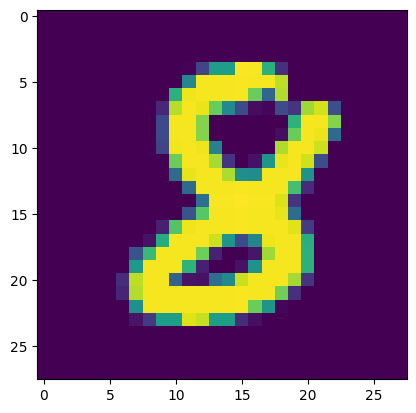

In [ ]:
for i, (images, _) in enumerate(dataloader):
    if i == 0:
        image = images[0]
        break
plt.imshow(image.permute(1, 2, 0))
plt.show()

# Training Process

Epoch [1/50], Step [200/468], Generator Loss: 0.6945, Discriminator Loss: 1.3895
Epoch [1/50], Step [400/468], Generator Loss: 0.6937, Discriminator Loss: 1.3874
Generated images saved for epoch 1
Epoch [2/50], Step [200/468], Generator Loss: 0.6936, Discriminator Loss: 1.3870
Epoch [2/50], Step [400/468], Generator Loss: 0.6936, Discriminator Loss: 1.3869
Epoch [3/50], Step [200/468], Generator Loss: 0.6933, Discriminator Loss: 1.3866
Epoch [3/50], Step [400/468], Generator Loss: 0.6934, Discriminator Loss: 1.3866
Epoch [4/50], Step [200/468], Generator Loss: 0.6933, Discriminator Loss: 1.3865
Epoch [4/50], Step [400/468], Generator Loss: 0.6933, Discriminator Loss: 1.3866
Epoch [5/50], Step [200/468], Generator Loss: 0.6932, Discriminator Loss: 1.3864
Epoch [5/50], Step [400/468], Generator Loss: 0.6932, Discriminator Loss: 1.3865
Epoch [6/50], Step [200/468], Generator Loss: 0.6932, Discriminator Loss: 1.3864
Epoch [6/50], Step [400/468], Generator Loss: 0.6932, Discriminator Loss: 

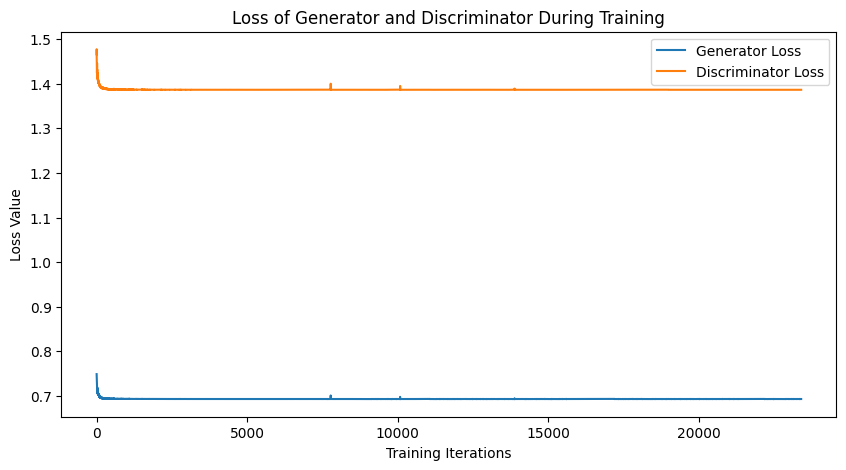

In [ ]:

def train_gan(num_epochs, dataloader, my_generator, my_discriminator, disc_optimizer, gen_optimizer, device):
    """
    Train the GAN model by alternating between updating the discriminator and the generator.

    Parameters:
        num_epochs (int): The number of epochs to train the GAN.
        dataloader (DataLoader): DataLoader for loading batches of real images.
        my_generator (nn.Module): The generator model.
        my_discriminator (nn.Module): The discriminator model.
        disc_optimizer (torch.optim.Optimizer): Optimizer for the discriminator.
        gen_optimizer (torch.optim.Optimizer): Optimizer for the generator.
        device (torch.device): The device to perform computations on (CPU or GPU).

    Returns:
        generator_losses (list): List of generator loss values during training.
        discriminator_losses (list): List of discriminator loss values during training.
    """
    generator_losses = []  # List to track generator loss values
    discriminator_losses = []  # List to track discriminator loss values

    # Specify epochs for saving generated images: beginning, middle, and end
    image_save_epochs = [1, num_epochs // 2, num_epochs]  # Capture images at specified epochs
    latent_vector_size = 64  # Size of the latent vector

    # Iterate through each epoch
    for epoch in range(num_epochs):
        for idx, (batch_images, _) in enumerate(dataloader):
            # (a) Update the Discriminator
            my_discriminator.zero_grad()  # Clear gradients for the discriminator
            real_batch = batch_images.to(device)  # Transfer real images to the specified device
            current_batch_size = real_batch.size(0)  # Determine the current batch size

            # 1. Generate synthetic images
            latent_vectors = torch.randn(current_batch_size, latent_vector_size, device=device)  # Create random latent vectors
            synthetic_images = my_generator(latent_vectors)  # Produce synthetic images using the generator

            # 2. Get discriminator outputs for real and synthetic images
            real_output = my_discriminator(real_batch).squeeze()  # Discriminator's output for real images
            synthetic_output = my_discriminator(synthetic_images.detach()).squeeze()  # Discriminator's output for synthetic images (detached)

            # 3. Calculate discriminator loss and perform an update
            disc_loss = compute_discriminator_loss(real_output, synthetic_output)  # Calculate discriminator loss
            disc_loss.backward()  # Backpropagate the loss
            disc_optimizer.step()  # Update discriminator parameters

            # (b) Update the Generator
            my_generator.zero_grad()  # Clear gradients for the generator
            # Generate synthetic images again
            latent_vectors = torch.randn(current_batch_size, latent_vector_size, device=device)  # Create new random latent vectors
            synthetic_images = my_generator(latent_vectors)  # Generate new synthetic images

            # Get discriminator output for the new synthetic images
            synthetic_output = my_discriminator(synthetic_images).squeeze()  # Discriminator's output for synthetic images

            # Calculate generator loss and perform an update
            gen_loss = compute_generator_loss(synthetic_output)  # Calculate generator loss
            gen_loss.backward()  # Backpropagate the loss
            gen_optimizer.step()  # Update generator parameters

            # Record loss values
            generator_losses.append(gen_loss.item())  # Store generator loss
            discriminator_losses.append(disc_loss.item())  # Store discriminator loss

            # Print loss values every 200 iterations
            if (idx + 1) % 200 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], Step [{idx + 1}/{len(dataloader)}], "
                    f"Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}"
                )

        # (c) Save generated images at specified epochs
        if (epoch + 1) in image_save_epochs:
            with torch.no_grad():  # Disable gradient tracking for inference
                latent_vectors = torch.randn(10 * 10, latent_vector_size, device=device)  # Create a grid of latent vectors
                generated_images = my_generator(latent_vectors).cpu()  # Generate images and move to CPU for display

                # Normalize images to the [0, 1] range
                generated_images = (generated_images + 1) / 2  # Assuming outputs range from [-1, 1]

                # Visualize the generated images
                fig, axes = plt.subplots(10, 10, figsize=(10, 10))  # Create a grid of subplots
                for row in range(10):
                    for col in range(10):
                        img_index = row * 10 + col  # Compute index for the image
                        axes[row, col].imshow(generated_images[img_index].squeeze(), cmap='gray')  # Display the image
                        axes[row, col].axis('off')  # Hide axes
                        axes[row, col].text(0.5, -0.2, str(img_index), fontsize=8, ha='center', transform=axes[row, col].transAxes)  # Add image index

                # Save the generated images to a file
                plt.savefig(os.path.join('./', f"generated_images_epoch_{epoch + 1}.png"))
                print(f"Generated images saved for epoch {epoch + 1}")
                plt.close(fig)  # Close the figure to free memory

    return generator_losses, discriminator_losses  # Return the recorded losses

def visualize_loss(generator_losses, discriminator_losses):
    """
    Visualize and save the loss values for the generator and discriminator.

    Parameters:
        generator_losses (list): List of generator loss values during training.
        discriminator_losses (list): List of discriminator loss values during training.
    """
    # (d) Visualizing the Loss
    plt.figure(figsize=(10, 5))  # Create a new figure with the specified dimensions
    plt.title("Loss of Generator and Discriminator During Training")  # Set the title for the plot
    plt.plot(generator_losses, label="Generator Loss")  # Plot generator loss with a label
    plt.plot(discriminator_losses, label="Discriminator Loss")  # Plot discriminator loss with a label
    plt.xlabel("Training Iterations")  # Label for the x-axis
    plt.ylabel("Loss Value")  # Label for the y-axis
    plt.legend()  # Display a legend to differentiate between generator and discriminator losses

    # Save the loss plot to a file
    plt.savefig(os.path.join('./', "loss_visualization.png"))  # Save the plot with a new name
    print("Loss visualization saved")  # Print a confirmation message

    plt.show()  # Show the plot to the user

# Example usage (assuming required variables are defined)
# generator_losses, discriminator_losses = train_gan(num_epochs, dataloader, my_generator, my_discriminator, disc_optimizer, gen_optimizer, device)
# visualize_loss(generator_losses, discriminator_losses)

# Compute FID

In [ ]:


def save_real_images(dataset, max_images=5000, save_dir="./real_images"):
    """
    Save real images from the dataset to a specified directory.

    Parameters:
        dataset (iterable): The dataset containing images.
        max_images (int): Maximum number of images to save.
        save_dir (str): Directory to save the images.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
    for index, (image, _) in enumerate(dataset):
        if index >= max_images:
            break
        plt.imsave(f"{save_dir}/{index}.png", image.squeeze().numpy(), cmap='gray')

def save_fake_images(generator, num_images=5000, batch_size=128, latent_dim=64, save_dir="./fake_images"):
    """
    Generate and save fake images produced by the generator.

    Parameters:
        generator (nn.Module): The generator model.
        num_images (int): Total number of fake images to generate.
        batch_size (int): Number of images to generate in each batch.
        latent_dim (int): Dimensionality of the latent space.
        save_dir (str): Directory to save the fake images.
    """
    fake_images_list = []
    for _ in range(num_images // batch_size):  # Generate enough images to reach the desired count
        latent_vectors = torch.randn(batch_size, latent_dim).to(device)  # Sample random latent vectors
        fake_images_batch = generator(latent_vectors).cpu().detach()  # Generate fake images
        fake_images_list.append(fake_images_batch)

    fake_images = torch.cat(fake_images_list)[:num_images]  # Select only the desired number of images

    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
    for idx, image in enumerate(fake_images):
        plt.imsave(f"{save_dir}/{idx}.png", image.squeeze(), cmap='gray')

# Save real images from the dataset
save_real_images(dataset)

# Save fake images generated by the model
save_fake_images(my_generator)

# Verify the number of saved images
print(f"Number of real images saved: {len(os.listdir('./real_images'))}")
print(f"Number of fake images saved: {len(os.listdir('./fake_images'))}")

# Calculate and print FID score
fid_value = fid_score.calculate_fid_given_paths(
    ["./real_images", "./fake_images"],
    batch_size=50,
    device=device,
    dims=2048
)
print(f"FID Score is: {fid_value:.3f}")

Number of real images saved: 5000
Number of fake images saved: 4992


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 360MB/s]
100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


FID Score: 399.76


# WGAN

In [ ]:
import torch.nn as nn  # Import the PyTorch neural network module

### Cell 2: Define the architecture of the Discriminator
class Discriminator(nn.Module):
    """
    A neural network model representing the Discriminator in a Wasserstein GAN.

    This model takes an input image and outputs a single score indicating the quality of the image,
    with higher scores indicating better quality. The architecture consists of convolutional layers
    followed by fully connected layers, utilizing ReLU and Leaky ReLU activation functions.
    """

    def __init__(self):
        """
        Initializes the Discriminator model architecture.
        Sets up the layers including convolutional, activation, flattening, and fully connected layers.
        """
        super().__init__()  # Initialize the base class

        # Define the model architecture as a sequential container
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # First conv layer: 1 input channel -> 32 output channels
            nn.LeakyReLU(0.2),  # Use Leaky ReLU activation function

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Second conv layer: 32 -> 64 channels
            nn.LeakyReLU(0.2),  # Use ReLU activation function

            nn.Flatten(),  # Flatten the output from the conv layers for the fully connected layers

            nn.Linear(64 * 7 * 7, 512),  # First fully connected layer: 64*7*7 inputs -> 512 outputs
            nn.LeakyReLU(0.2),  # Use Leaky ReLU activation function

            nn.Linear(512, 1)  # Final layer outputs a single score (discriminator's score for the input)
            # Note: No Sigmoid activation here, as WGAN uses raw scores for the Wasserstein distance
        )

    def forward(self, x):
        """
        Forward pass through the Discriminator model.

        Parameters:
            x (torch.Tensor): Input tensor representing the image batch.

        Returns:
            torch.Tensor: Output tensor containing the discriminator scores for the input images.
        """
        return self.main(x)  # Pass the input through the defined architecture


In [ ]:

from torch import autograd

# Function to calculate the gradient penalty for the Discriminator
def compute_gradient_penalty(discriminator, real_images, generated_images, device):
    """
    Calculate the gradient penalty for the Wasserstein GAN with gradient penalty (WGAN-GP).

    This penalty helps maintain the Lipschitz condition for the Discriminator.

    Parameters:
        discriminator (nn.Module): The Discriminator model.
        real_images (torch.Tensor): A batch of real image samples.
        generated_images (torch.Tensor): A batch of synthetic images produced by the generator.
        device (torch.device): The device for tensor operations (e.g., CPU or GPU).

    Returns:
        torch.Tensor: The calculated gradient penalty.
    """
    batch_size = real_images.size(0)  # Get the number of samples in the batch
    lambda_value = torch.rand(batch_size, 1, 1, 1).to(device)  # Random alpha values for interpolation

    # Generate interpolated images between real and generated images
    interpolated_images = (lambda_value * real_images + (1 - lambda_value) * generated_images).requires_grad_(True)

    # Get the Discriminator's output for the interpolated images
    discriminator_output = discriminator(interpolated_images)

    # Calculate gradients of the Discriminator's output with respect to the interpolated images
    gradients = autograd.grad(
        outputs=discriminator_output,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(discriminator_output),  # Gradient of outputs w.r.t. Discriminator's output
        create_graph=True,  # Enable gradient computation for higher order
        retain_graph=True,  # Keep the graph for further backward passes
    )[0]

    # Reshape the gradients to have shape (batch_size, -1)
    gradients = gradients.view(gradients.size(0), -1)

    # Compute the gradient penalty term
    gradient_penalty_value = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # WGAN-GP penalty
    return gradient_penalty_value  # Return the computed penalty


# Function to calculate the loss for the Discriminator
def calculate_discriminator_loss(real_scores, generated_scores, gradient_penalty_value, penalty_weight=10):
    """
    Compute the loss for the Discriminator in a WGAN-GP framework.

    The loss encourages the Discriminator to output higher scores for real images and lower scores for generated images,
    while incorporating the gradient penalty to stabilize training.

    Parameters:
        real_scores (torch.Tensor): Scores assigned by the Discriminator to real images.
        generated_scores (torch.Tensor): Scores assigned to generated images.
        gradient_penalty_value (torch.Tensor): The calculated gradient penalty.
        penalty_weight (float): The coefficient for the gradient penalty term.

    Returns:
        torch.Tensor: The computed Discriminator loss.
    """

    return -torch.mean(real_scores) + torch.mean(generated_scores) + penalty_weight * gradient_penalty_value
    # -mean(real_scores): Promotes higher scores for real images
    # mean(generated_scores): Promotes lower scores for generated images
    # penalty_weight * gradient_penalty_value: Adds the gradient penalty for stability


# Function to compute the loss for the Generator
def calculate_generator_loss(generated_scores):
    """
    Calculate the loss for the Generator in a WGAN-GP.

    The loss incentivizes the Generator to produce images that receive high scores from the Discriminator.

    Parameters:
        generated_scores (torch.Tensor): Scores assigned by the Discriminator to generated images.

    Returns:
        torch.Tensor: The computed Generator loss.
    """

    return -torch.mean(generated_scores)  # Encourages the Generator to produce better quality images

# Train Wgan

Epoch [1/20], Step [200/468], Loss_D: -61.8245, Loss_G: -16.6357
Epoch [1/20], Step [400/468], Loss_D: -52.0797, Loss_G: -44.5989
Epoch [2/20], Step [200/468], Loss_D: -44.5897, Loss_G: -37.3412
Epoch [2/20], Step [400/468], Loss_D: -42.8821, Loss_G: -28.5511
Epoch [3/20], Step [200/468], Loss_D: -41.7696, Loss_G: -19.2879
Epoch [3/20], Step [400/468], Loss_D: -41.8732, Loss_G: -19.8364
Epoch [4/20], Step [200/468], Loss_D: -41.5275, Loss_G: -18.3217
Epoch [4/20], Step [400/468], Loss_D: -41.5299, Loss_G: -18.4038
Epoch [5/20], Step [200/468], Loss_D: -41.4335, Loss_G: -16.0815
Epoch [5/20], Step [400/468], Loss_D: -41.5518, Loss_G: -16.5647
Epoch [6/20], Step [200/468], Loss_D: -41.1173, Loss_G: -16.5057
Epoch [6/20], Step [400/468], Loss_D: -41.6216, Loss_G: -16.0258
Epoch [7/20], Step [200/468], Loss_D: -41.8893, Loss_G: -14.7626
Epoch [7/20], Step [400/468], Loss_D: -41.7343, Loss_G: -14.0998
Epoch [8/20], Step [200/468], Loss_D: -41.9504, Loss_G: -13.4412
Epoch [8/20], Step [400/4

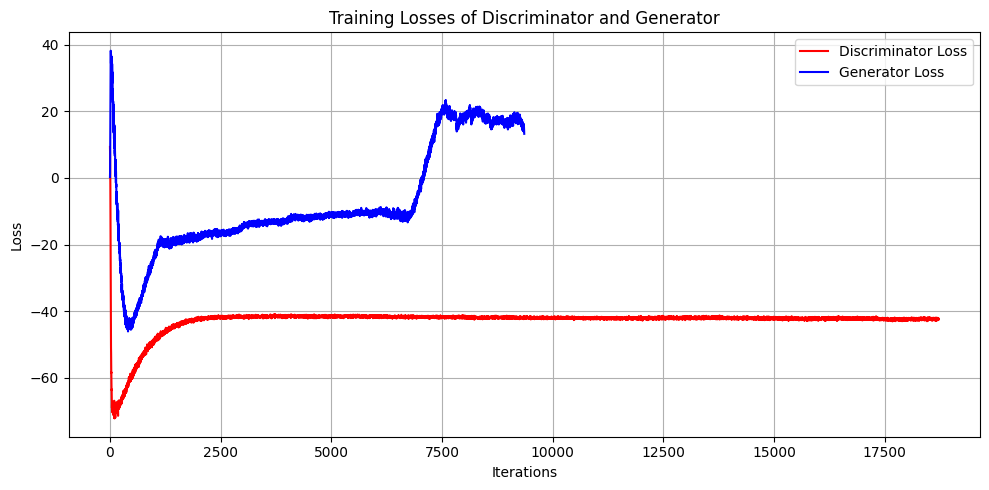

In [ ]:

# Hyperparameters
num_critic_iterations = 2  # Number of iterations to train the Discriminator
gradient_penalty_weight = 10  # Common value for the gradient penalty
discriminator_losses = []  # List to store Discriminator losses
generator_losses = []  # List to store Generator losses

# Initialize the Generator and Discriminator
latent_dimension = 64  # Dimension of the latent space for the generator
num_epochs = 20
generator_model = MyGenerator(latent_dimension).to(device)  # Instantiate the generator
discriminator_model = Discriminator().to(device)  # Instantiate the Discriminator

# Optimizers for both models
optimizer_generator = optim.Adam(generator_model.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_discriminator = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(0.5, 0.9))

# Training loop
for epoch in range(num_epochs):
    for batch_index, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)  # Move real images to the specified device

        # Train the Discriminator
        for _ in range(num_critic_iterations):
            optimizer_discriminator.zero_grad()  # Clear gradients for Discriminator

            # Generate random noise and fake images
            noise = torch.randn(real_images.size(0), latent_dimension).to(device)  # Latent vectors
            generated_images = generator_model(noise)  # Generate fake images

            # Calculate the gradient penalty
            gp = compute_gradient_penalty(discriminator_model, real_images, generated_images, device)

            # Get scores from the Discriminator for real and generated images
            real_scores = discriminator_model(real_images)  # Discriminator scores for real images
            fake_scores = discriminator_model(generated_images)  # Discriminator scores for fake images

            # Calculate the Discriminator loss
            discriminator_loss_value = calculate_discriminator_loss(real_scores, fake_scores, gp, gradient_penalty_weight)

            # Backpropagate and update the Discriminator
            discriminator_loss_value.backward(retain_graph=True)  # Retain graph for later use
            optimizer_discriminator.step()  # Update Discriminator parameters

            # Record the Discriminator loss
            discriminator_losses.append(discriminator_loss_value.item())

        # Train the Generator
        optimizer_generator.zero_grad()  # Clear gradients for Generator

        # Get the scores for the generated images from the Discriminator
        fake_scores = discriminator_model(generated_images)  # Discriminator scores for generated images

        # Calculate the Generator loss
        generator_loss_value = calculate_generator_loss(fake_scores)

        # Backpropagate and update the Generator
        generator_loss_value.backward()  # Backpropagate the loss
        optimizer_generator.step()  # Update Generator parameters

        # Record the Generator loss
        generator_losses.append(generator_loss_value.item())

        # Print loss statistics every 200 steps
        if (batch_index + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{batch_index + 1}/{len(dataloader)}], "
                f"Loss_D: {discriminator_loss_value.item():.4f}, Loss_G: {generator_loss_value.item():.4f}"
            )

import matplotlib.pyplot as plt  # Importing matplotlib for visualization

# Function to plot the training losses of the Discriminator and Generator
def plot_training_losses(discriminator_losses, generator_losses):
    """
    Plots the losses of the Discriminator and Generator during training.

    Parameters:
        discriminator_losses (list): A list of loss values for the Discriminator.
        generator_losses (list): A list of loss values for the Generator.
    """
    plt.figure(figsize=(10, 5))  # Set the figure size for better visibility
    plt.plot(discriminator_losses, label='Discriminator Loss', color='red')  # Plot the Discriminator loss
    plt.plot(generator_losses, label='Generator Loss', color='blue')  # Plot the Generator loss
    plt.xlabel('Iterations')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.title('Training Losses of Discriminator and Generator')  # Set the title of the plot
    plt.legend()  # Show legend to differentiate between Discriminator and Generator losses
    plt.grid(True)  # Add a grid for better readability
    plt.tight_layout()  # Automatically adjust subplot parameters for a better fit
    plt.show()  # Display the plot

# Example usage
plot_training_losses(discriminator_losses, generator_losses)  # Call the plotting function


# Generator Image

In [ ]:
latent_dimension = 64  # Dimension of the latent space for the generator
# Function to save real images from the dataset
def save_real_images(dataset, max_images=5000):
    """
    Saves a specified number of real images from the dataset to a directory.

    Parameters:
        dataset (iterable): An iterable dataset containing image data.
        max_images (int): The maximum number of images to save.
    """
    os.makedirs("./real_images", exist_ok=True)  # Create directory for real images
    for index, (image, _) in enumerate(dataset):
        if index >= max_images:  # Stop after saving the specified number of images
            break
        plt.imsave(f"./real_images/{index}.png", image.squeeze().numpy(), cmap='gray')  # Save image as .png

# Function to generate and save fake images
def generate_and_save_fake_images(generator, num_images=5000, batch_size=64):
    """
    Generates fake images using the generator model and saves them to a directory.

    Parameters:
        generator (nn.Module): The generator model used for creating images.
        num_images (int): The total number of fake images to generate and save.
        batch_size (int): The number of images to generate in each batch.
    """
    generated_images = []  # List to hold generated images
    for _ in range(num_images // batch_size):  # Generate images in batches
        noise = torch.randn(batch_size, latent_dimension).to(device)  # Generate random noise
        fake_images_batch = generator(noise).cpu().detach()  # Generate fake images
        generated_images.append(fake_images_batch)  # Append batch to the list
    generated_images = torch.cat(generated_images)[:num_images]  # Concatenate batches and select the desired number

    # Create directory for fake images
    os.makedirs("./fake_images_wgan", exist_ok=True)
    for idx, img in enumerate(generated_images):
        plt.imsave(f"./fake_images_wgan/{idx}.png", img.squeeze(), cmap='gray')  # Save each fake image

# Function to verify saved images and calculate FID score
def verify_and_calculate_fid():
    """
    Verifies the number of real and fake images saved in their respective directories
    and calculates the FID score between them.
    """
    # Verify the number of saved images
    print(f"Number of Real Images: {len(os.listdir('./real_images'))}")
    print(f"Number of Fake Images: {len(os.listdir('./fake_images_wgan'))}")

    # Calculate FID score between real and fake images
    fid_value = fid_score.calculate_fid_given_paths(
        ["./real_images", "./fake_images_wgan"],
        batch_size=50,
        device=device,
        dims=2048
    )
    print(f"FID Score: {fid_value:.2f}")

# Example usage of the functions
save_real_images(dataset)  # Save real images from the dataset
generate_and_save_fake_images(my_generator, num_images=5000, batch_size=64)  # Generate and save fake images
verify_and_calculate_fid()  # Verify and calculate FID score

Number of Real Images: 5000
Number of Fake Images: 4992


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


FID Score: 422.67


#SSGAN Model for Generator

In [ ]:
import torch.nn as nn

### Cell 4: Define Residual Block for Generator
class ResidualBlockG(nn.Module):
    """
    A Residual Block used in the Generator to facilitate learning
    by allowing gradients to flow more easily through the network.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        upsample (bool): Flag indicating whether to upsample the input.
    """
    def __init__(self, in_channels, out_channels, upsample=True):
        super().__init__()
        self.upsample = upsample  # Flag to determine whether to upsample the input

        # Main sequential block comprising batch normalization, ReLU activations, and convolutions
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),  # Normalize the input
            nn.ReLU(),  # Apply ReLU activation
            nn.Upsample(scale_factor=2, mode='nearest') if upsample else nn.Identity(),  # Upsample if specified
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # First convolution layer
            nn.BatchNorm2d(out_channels),  # Normalize after the first convolution
            nn.ReLU(),  # Apply ReLU activation again
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # Second convolution layer
        )

        # Shortcut connection to add input directly to the output
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest') if upsample else nn.Identity(),  # Upsample if necessary
            # Uncomment to use a 1x1 convolution for matching dimensions:
            # nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 convolution for dimension matching
        )

    def forward(self, x):
        """
        Forward pass for the residual block.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the residual block.
        """
        # Combine the output of the main block with the shortcut connection
        return self.block(x) + self.shortcut(x)


### Cell 5: Implement Generator with Architecture from Table 4
class SSGenerator(nn.Module):
    """
    The Generator class for the Super Resolution model that generates
    high-resolution images from random latent vectors.

    Attributes:
        latent_dim (int): Dimension of the latent space.
    """
    def __init__(self, latent_dim=128):
        super().__init__()
        # Initial layer that projects the latent vector into a higher-dimensional space
        self.init_layer = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),  # Fully connected layer to create a feature map
            nn.BatchNorm1d(256 * 4 * 4),  # Normalize the features
        )

        # Sequential layers of residual blocks to upscale and refine the generated images
        self.res_blocks = nn.Sequential(
            ResidualBlockG(256, 256, upsample=True),  # First residual block for upsampling
            ResidualBlockG(256, 256, upsample=True),  # Second residual block for upsampling
            ResidualBlockG(256, 256, upsample=True),  # Third residual block for further refinement
            nn.ReLU()  # Apply ReLU activation after residual blocks
        )

        # Final layers to produce the output image
        self.final_layers = nn.Sequential(
            # Uncomment for additional normalization if needed:
            # nn.BatchNorm2d(256),  # Normalize before the final output
            # nn.ReLU(),  # Apply ReLU activation before the final layer
            nn.Conv2d(256, 1, kernel_size=3, padding=1),  # Final convolution to reduce channels to 1 (for grayscale)
            nn.Tanh()  # Tanh activation to scale output to the range [-1, 1]
        )

    def forward(self, z):
        """
        Forward pass through the generator.

        Parameters:
            z (torch.Tensor): Latent vector of shape (batch_size, latent_dim).

        Returns:
            torch.Tensor: Generated image of shape (batch_size, 1, height, width).
        """
        # Pass the latent vector through the initial layer
        x = self.init_layer(z)  # Expand latent vector into a feature map
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch_size, channels, height, width)
        x = self.res_blocks(x)  # Pass through the residual blocks for upsampling
        return self.final_layers(x)  # Pass through final layers to obtain the generated image

# SSGAN for Discrimentor

In [ ]:


# Definition of Residual Block for the Discriminator
class ResidualBlockD(nn.Module):
    """
    A Residual Block for the Discriminator that enables the network to learn residual mappings.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        downsample (bool): Flag indicating whether to downsample the input.
    """
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        self.downsample = downsample  # Indicates if this block is responsible for downsampling

        # Block 1: Convolution and activation
        self.block1 = nn.Sequential(
            nn.ReLU() if not downsample else nn.Identity(),  # Apply ReLU unless downsampling
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Convolution layer (3x3)
            nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),  # Apply spectral normalization
            nn.ReLU(),  # ReLU activation
        )

        # Block 2: Convolution and pooling
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Convolution layer (3x3)
            nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),  # Apply spectral normalization
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),  # Average pooling (2x2)
        )

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),  # 1x1 Convolution for dimension matching
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),  # Average pooling (2x2)
        )

    def forward(self, x):
        """
        Forward pass for the Residual Block.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the residual block.
        """
        # Process input through Block 1
        out1 = self.block1(x)

        # Process through Block 2
        out2 = self.block2(out1)

        # Compute the shortcut connection
        shortcut = self.shortcut(x)

        # Combine the processed output with the shortcut connection
        return out2 + shortcut


# Definition of Discriminator for Super Resolution GAN (SSGAN)
class SSDiscriminator(nn.Module):
    """
    The Discriminator class for the Super Resolution GAN, which distinguishes between real and fake images.

    Attributes:
        res_blocks (nn.Sequential): A sequence of residual blocks for processing input images.
        final_layers (nn.Sequential): Final layers to classify images and perform self-supervised tasks.
    """
    def __init__(self):
        super().__init__()

        # Series of residual blocks that progressively downsample and refine the input images
        self.res_blocks = nn.Sequential(
            ResidualBlockD(1, 128, downsample=True),  # First block (downsampling)
            ResidualBlockD(128, 128),  # Second block (no downsampling)
            ResidualBlockD(128, 128),  # Third block (no downsampling)
            ResidualBlockD(128, 128),  # Fourth block (no downsampling)
        )

        # Final layers to produce outputs for classification and self-supervised learning
        self.final_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 1),  # Fully connected layer for real/fake classification
            nn.Linear(128 * 3 * 3, 4),  # Fully connected layer for self-supervised tasks (e.g., rotation prediction)
        )

    def forward(self, x):
        """
        Forward pass through the Discriminator.

        Parameters:
            x (torch.Tensor): Input tensor representing an image.

        Returns:
            tuple: Outputs for real/fake classification and self-supervised tasks.
        """
        # Pass the input through the residual blocks
        x = self.res_blocks(x)  # Process through residual blocks
        x = x.view(x.size(0), -1)  # Flatten the output for the final layers

        # Obtain outputs for real/fake classification and self-supervised learning
        real_fake_output = self.final_layers[0](x)  # Output for real/fake classification
        self_supervised_output = self.final_layers[1](x)  # Output for self-supervised task

        return real_fake_output, self_supervised_output

In [ ]:

img = SSGenerator()
ss = torchinfo.summary(img,input_size=(1,128))
print(f"SSGenerator is:{ss}")


block = ResidualBlockG(256, 256, upsample=True)
re = torchinfo.summary(block, input_size=(1, 256, 4, 4))
print(f"ResidualBlockG is:{re}")

# Train SSGAN Model

In [ ]:


# Instantiate the Generator and Discriminator using previously defined classes
generator = SSGenerator(latent_dim=128).to(device)  # Create the Generator model
discriminator = SSDiscriminator().to(device)  # Create the Discriminator model

# Define optimizers for both models
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for Generator
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for Discriminator

# Define loss functions
criterion = nn.BCEWithLogitsLoss()  # Loss function for real/fake classification
criterion_ss = nn.CrossEntropyLoss()  # Loss function for self-supervised tasks (e.g., rotation prediction)

# Lists to store loss values for analysis
g_losses = []  # Generator losses
d_losses = []  # Discriminator losses

# Number of epochs for training
num_epochs = 10
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)  # Move real images to the specified device
        batch_size = real_images.size(0)  # Get the current batch size

        # (a) Train the Discriminator
        discriminator.zero_grad()  # Clear previous gradients

        # 1. Train with real images
        real_labels = torch.ones(batch_size, 1).to(device)  # Labels for real images
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Labels for fake images

        # Get the Discriminator's output for real images
        real_output, real_ss_output = discriminator(real_images)  # Forward pass through Discriminator
        d_loss_real = criterion(real_output, real_labels)  # Compute loss for real images

        # 2. Train with fake images
        z = torch.randn(batch_size, 128).to(device)  # Sample random latent vectors from normal distribution
        fake_images = generator(z)  # Generate fake images using the Generator
        fake_output, fake_ss_output = discriminator(fake_images.detach())  # Get output from Discriminator
        d_loss_fake = criterion(fake_output, fake_labels)  # Compute loss for fake images

        # 3. Self-supervised task (e.g., rotation prediction)
        # Generate random rotation labels for self-supervised learning (0°, 90°, 180°, 270°)
        rotation_labels = torch.randint(0, 4, (batch_size,)).to(device)  # Random rotation labels
        d_loss_ss = criterion_ss(real_ss_output, rotation_labels)  # Compute self-supervised loss

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake + d_loss_ss  # Combine all losses
        d_loss.backward()  # Backpropagate the loss
        optimizer_D.step()  # Update Discriminator weights

        # (b) Train the Generator
        generator.zero_grad()  # Clear previous gradients for the Generator

        # Generate fake images again for Generator training
        z = torch.randn(batch_size, 128).to(device)  # Sample new random latent vectors
        fake_images = generator(z)  # Generate fake images
        fake_output, _ = discriminator(fake_images)  # Get Discriminator output for fake images

        # Compute Generator loss
        g_loss = criterion(fake_output, real_labels)  # Loss for the Generator
        g_loss.backward()  # Backpropagate the loss
        optimizer_G.step()  # Update Generator weights

        # Store loss values for analysis
        g_losses.append(g_loss.item())  # Append Generator loss
        d_losses.append(d_loss.item())  # Append Discriminator loss

        # Print loss values every 100 steps for monitoring
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], "
                  f"Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}")

    # Save generated images at the end of each epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():  # Disable gradient calculation for image generation
            z = torch.randn(100, 128).to(device)  # Generate 100 random latent vectors
            generated_images = generator(z).cpu()  # Generate images and move to CPU

            # Save generated images in a grid format
            fig, axs = plt.subplots(10, 10, figsize=(10, 10))  # Create a 10x10 grid for displaying images
            for i in range(10):
                for j in range(10):
                    img_idx = i * 10 + j  # Calculate the index of the image
                    axs[i, j].imshow(generated_images[img_idx].squeeze(), cmap='gray')  # Display image in grayscale
                    axs[i, j].axis('off')  # Turn off axis for visual clarity
            plt.savefig(f"generated_images_epoch_{epoch + 1}.png")  # Save the figure as an image file
            plt.close(fig)  # Close the figure to free up memory

Epoch [1/10], Step [100/468], Loss_D: 1.4132, Loss_G: 6.1355
Epoch [1/10], Step [200/468], Loss_D: 1.4166, Loss_G: 7.4148
Epoch [1/10], Step [300/468], Loss_D: 1.3753, Loss_G: 8.2450
Epoch [1/10], Step [400/468], Loss_D: 1.3844, Loss_G: 8.3841
Epoch [2/10], Step [100/468], Loss_D: 1.3794, Loss_G: 8.9508
Epoch [2/10], Step [200/468], Loss_D: 1.4021, Loss_G: 9.9988
Epoch [2/10], Step [300/468], Loss_D: 1.3982, Loss_G: 9.9628
Epoch [2/10], Step [400/468], Loss_D: 1.3912, Loss_G: 10.4513
Epoch [3/10], Step [100/468], Loss_D: 1.3895, Loss_G: 10.2336
Epoch [3/10], Step [200/468], Loss_D: 1.3967, Loss_G: 11.2450
Epoch [3/10], Step [300/468], Loss_D: 1.3911, Loss_G: 12.8163
Epoch [3/10], Step [400/468], Loss_D: 1.4012, Loss_G: 7.8624
Epoch [4/10], Step [100/468], Loss_D: 1.4070, Loss_G: 8.2739
Epoch [4/10], Step [200/468], Loss_D: 1.3993, Loss_G: 9.8374
Epoch [4/10], Step [300/468], Loss_D: 1.3940, Loss_G: 9.2815
Epoch [4/10], Step [400/468], Loss_D: 1.3968, Loss_G: 10.1522
Epoch [5/10], Step 

# Computed FID

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Create a directory for storing real images
os.makedirs("./real_ssgan", exist_ok=True)

# Save a maximum of 5000 real images from the dataset
for index, (image, _) in enumerate(dataset):
    if index >= 5000:
        break
    plt.imsave(f"./real_ssgan/{index}.png", image.squeeze().numpy(), cmap='gray')

# Generate fake images using the generator
num_fake_batches = 100  # Number of batches to generate
generated_images = []  # List to hold generated images

# Create fake images by sampling random latent vectors
for _ in range(num_fake_batches):
    latent_vector = torch.randn(batch_size, 128).to(device)  # Sample random latent vectors
    fake_image_batch = generator_model(latent_vector).cpu().detach()  # Generate fake images
    print(fake_image_batch.shape)  # Print the shape of the generated batch
    generated_images.append(fake_image_batch)

# Concatenate all generated images and select the first 5000 samples
generated_images = torch.cat(generated_images)[:5000]

# Create a directory for storing fake images
os.makedirs("./fake_ssgan", exist_ok=True)

# Save the generated fake images to the specified directory
for idx, img in enumerate(generated_images):
    plt.imsave(f"./fake_ssgan/{idx}.png", img.squeeze(), cmap='gray')

# Calculate the FID score between real and generated images
fid_score_value = fid_score.calculate_fid_given_paths(
    ["./real_ssgan", "./fake_ssgan"],
    batch_size=50,
    device=device,
    dims=2048
)

# Print the calculated FID score
print(f"Calculated FID Score: {fid_score_value:.3f}")


torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([12

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Calculated FID Score: 399.464
